# Projet Data Science - Simulateur de DPE
## ENSAE Paris - 2A

Membres du groupe : 
- Wiam LACHQER , Amine RAZIG , Julien BOUDIER

Ce projet Python a été créé dans le but de fournir des visualisations variées des données et de mettre en place un simulateur de Diagnostic de Performance Energétique (DPE) à partir de la base de données de l'ADEME (Agence de la Transition Écologique).

## Objectifs du Projet

1. **Visualisations de Données :** Le projet propose différentes visualisations des données issues de la base de l'ADEME. Ces visualisations permettent une compréhension approfondie des caractéristiques énergétiques des logements.

2. **Simulateur de DPE :** Un simulateur de DPE sera développé en utilisant les données de l'ADEME. Ce simulateur permet d'estimer la performance énergétique d'un logement en fonction de divers paramètres.


Ce simulateur fournit une estimation de la consommation énergétique et du volume des émissions de gaz à effet de serre par an et par m² en se basant sur les caractéristiques du logement. La base de données disponible sur le site contient 210 colonnes, on est amenés à choisir une trentaine de variables pour minimiser le coût de la modélisation. 
Pour ce faire, on s’est inspirés des simulateurs disponibles en ligne (comme celui-ci https://diagnosticdpe.com/estimer-DPE.php), les informations demandées doivent être accessibles pour le propriétaire. Certaines colonnes sont supprimées puisque le nombre de leurs valeurs manquantes est très élevé, ce qui n’est pas pratique pour la modélisation.


 Pour plus de détail sur l’étiquette DPE: https://www.choisir.com/energie/articles/199743/tout-savoir-sur-le-calcul-du-dpe

In [ ]:
!pip install -q -r requirements.txt

In [150]:
# Importation des librairies qu’on va utiliser

import fetchdata   # ce fichier contient une fonction qui permet de récupérer les données en utilisant l’API
import eda         # ce fichier contient des fonctions pour l’exploration de la base de données et pour l’encodage 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
import plotly.express as px
import contextily as ctx
import cartiflette as s3
import folium
from folium.plugins import MarkerCluster



import sklearn.linear_model 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import  MultiTaskLassoCV

from sklearn.preprocessing import StandardScaler

from sklearn import linear_model
from sklearn.metrics import  mean_absolute_error, r2_score, accuracy_score, ConfusionMatrixDisplay

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline



## Importation des données :

In [48]:
# IMPORTATION DE LA LISTE DES VARIABLES DISPONIBLES SUR L'API : 

liste_variables = pd.read_excel('DATA/DPE_data_descrption.xlsx').drop(['OPEN DATA LOGEMENT EXISTANT','OPEN DATA LOGEMENT NEUF','OPEN DATA TERTIAIRE'], axis =1)
print("le nombre de colonnes de la base de données initiale :",liste_variables.shape)
liste_variables.head(3)

le nombre de colonnes de la base de données initiale : (210, 3)


Catégorie                     Nom_champ  \
0  Administratif  Appartement_non_visité_(0/1)   
1  Administratif        Date_établissement_DPE   
2  Administratif         Date_fin_validité_DPE   

                                         Description  
0  est ce que l'appartement est un appartement no...  
1                     date de l'établissement du dpe  
2                     Date de fin de validité du DPE

Importer la totalité des données peut prendre beaucoup de temps. Le paramètre "size" permet de restreindre le nombre d'observations à récupérer. Par défaut, la totalité des observations est récupérée. Les données sont également téléchargeable à l'adresse suivante :
https://www.data.gouv.fr/fr/datasets/dpe-logements-existants-depuis-juillet-2021/

In [49]:
# Import des données à partir de L'API : 

chosen_variables=['N°DPE',
                  'Etiquette_GES',
                  'Etiquette_DPE',
                  'Année_construction',
                  'Type_bâtiment',
                  'Période_construction',
                  'Hauteur_sous-plafond',
                  'Surface_habitable_logement',
                  'Classe_altitude',
                  'Zone_climatique_',
                  'Nom__commune_(BAN)',
                  'N°_département_(BAN)',
                  'Coordonnée_cartographique_X_(BAN)',     
                  'Coordonnée_cartographique_Y_(BAN)',
                  'N°_région_(BAN)',
                  'Conso_5_usages_é_finale',
                  'Conso_5_usages/m²_é_finale',
                  'Conso_chauffage_é_finale',
                  'Emission_GES_5_usages',
                  'Emission_GES_5_usages_par_m²',
                  'Conso_5_usages_é_finale_énergie_n°1',
                  'Conso_5_usages_é_finale_énergie_n°2',
                  'Coût_total_5_usages_énergie_n°2',
                  'Conso_5_usages_é_finale_énergie_n°3',
                  'Coût_total_5_usages',
                  'Qualité_isolation_enveloppe',
                  'Qualité_isolation_menuiseries',
                  'Qualité_isolation_murs',
                  'Qualité_isolation_plancher_bas',
                  'Type_énergie_principale_chauffage',
                  'Type_énergie_principale_ECS',
                  'Type_énergie_n°1',
                  'Type_énergie_n°2',
                  'Type_installation_ECS',
                  'Type_installation_solaire',
                  'Surface_climatisée',               
                  'Type_ventilation',
                  'Protection_solaire_exterieure_(0/1)',
                  'Isolation_toiture_(0/1)',
                  'Indicateur_confort_été']

df_DPE = fetchdata.get_dpe(chosen_variables, size =150000)
df_DPE.head(3)



Fetched 10000 observations
Fetched 20000 observations
Fetched 30000 observations
Fetched 40000 observations
Fetched 50000 observations
Fetched 60000 observations
Fetched 70000 observations
Fetched 80000 observations
Fetched 90000 observations
Fetched 100000 observations
Fetched 110000 observations
Fetched 120000 observations
Fetched 130000 observations
Fetched 140000 observations
Fetched 150000 observations


Type_énergie_n°1  Coût_total_5_usages_énergie_n°2  \
0  Réseau de Chauffage urbain                            286.6   
1                 Électricité                           2337.8   
2                 Électricité                            211.1   

             Type_énergie_n°2     Nom__commune_(BAN)  \
0                 Gaz naturel         Saint-Herblain   
1  Réseau de Chauffage urbain         Bourg-la-Reine   
2               Bois – Bûches  Saint-Romain-en-Jarez   

  Qualité_isolation_enveloppe  Coût_total_5_usages  Emission_GES_5_usages  \
0                insuffisante                702.1                 1027.7   
1                insuffisante               2337.8                 3672.5   
2                       bonne               2161.4                 1086.8   

           N°DPE Qualité_isolation_menuiseries Qualité_isolation_murs  ...  \
0  2144E0974339H                       moyenne           insuffisante  ...   
1  2192E1018146A                       moyenne           insuffisante  ...   
2  2342E0053692U                       moyenne                moyenne  ...   

  Zone_climatique_   Classe_altitude  Type_énergie_principale_ECS  \
0              NaN               NaN                          NaN   
1              H1a  inférieur à 400m   Réseau de Chauffage urbain   
2              H1c          400-800m                  Électricité   

   Type_énergie_principale_chauffage  Isolation_toiture_(0/1)  \
0                                NaN                      NaN   
1                        Électricité                      NaN   
2                        Électricité                     True   

   Protection_solaire_exterieure_(0/1)                     Type_ventilation  \
0                                  NaN                                  NaN   
1                                  NaN                                  NaN   
2                                False  VMC SF Auto réglable de 2001 à 2012   

  Indicateur_confort_été  Type_installation_solaire  Surface_climatisée  
0                    NaN                        NaN                 NaN  
1                    NaN                        NaN                 NaN  
2            insuffisant                        NaN                 NaN  

[3 rows x 41 columns]

## Mise en place de la base de données exploitable. 
L'objectif est de séléctionner et de modifier certaines variables afin qu'elles puissent être utilisées efficacement dans nos analyses.

### Traitement des valeurs manquantes : 

In [50]:
# Suppression des lignes dupliquées

df_DPE = df_DPE.drop_duplicates()


In [51]:
eda.create_unique(df_DPE)

Column_name Data_type Number_of_unique  \
0                      Type_énergie_n°1    object               12   
1       Coût_total_5_usages_énergie_n°2   float64            20510   
2                      Type_énergie_n°2    object               13   
3                    Nom__commune_(BAN)    object            15119   
4           Qualité_isolation_enveloppe    object                4   
5                   Coût_total_5_usages   float64            28157   
6                 Emission_GES_5_usages   float64            45457   
7                                 N°DPE    object           150000   
8         Qualité_isolation_menuiseries    object                4   
9                Qualité_isolation_murs    object                4   
10                        Etiquette_GES    object                7   
11  Conso_5_usages_é_finale_énergie_n°1   float64            94240   
12  Conso_5_usages_é_finale_énergie_n°2   float64            42240   
13  Conso_5_usages_é_finale_énergie_n°3   float64             5473   
14    Coordonnée_cartographique_X_(BAN)   float64            88601   
15             Conso_chauffage_é_finale   float64            92002   
16                        Type_bâtiment    object                3   
17                        Etiquette_DPE    object                7   
18                   Année_construction   float64              208   
19         Emission_GES_5_usages_par_m²   float64             1241   
20              Conso_5_usages_é_finale   float64            96603   
21                 N°_département_(BAN)    object               98   
22                      N°_région_(BAN)    object               15   
23       Qualité_isolation_plancher_bas    object                4   
24           Conso_5_usages/m²_é_finale   float64             5116   
25                 Hauteur_sous-plafond   float64               97   
26           Surface_habitable_logement   float64             2976   
27    Coordonnée_cartographique_Y_(BAN)   float64            88567   
28                 Période_construction    object               10   
29                               _score    object                0   
30                Type_installation_ECS    object                3   
31                     Zone_climatique_    object                8   
32                      Classe_altitude    object                3   
33          Type_énergie_principale_ECS    object               14   
34    Type_énergie_principale_chauffage    object               14   
35              Isolation_toiture_(0/1)    object                2   
36  Protection_solaire_exterieure_(0/1)    object                2   
37                     Type_ventilation    object               37   
38               Indicateur_confort_été    object                3   
39            Type_installation_solaire    object                4   
40                   Surface_climatisée   float64             1492   

   Number_of_missing  Percentage_of_missing  \
0                  0               0.000000   
1              53741               0.358273   
2              53741               0.358273   
3               1098               0.007320   
4                  0               0.000000   
5                123               0.000820   
6                122               0.000813   
7                  0               0.000000   
8                  0               0.000000   
9                  0               0.000000   
10                 0               0.000000   
11               123               0.000820   
12             53741               0.358273   
13            141505               0.943367   
14              1098               0.007320   
15               119               0.000793   
16                 0               0.000000   
17                 0               0.000000   
18              3150               0.021000   
19               122               0.000813   
20               123               0.000820   
21              2205               0.014700   
22    

On supprime "Surface_climatisée, Type_installation_solaire, _score, Conso_5_usages_é_finale_énergie_n°3,Coût_total_5_usages_énergie_n°3, Type_énergie_n°3, Protection_solaire_exterieure_(0/1), Isolation_toiture_(0/1), Indicateur_confort_été" puisque le nombre de valeurs manquantes dans chacune de ces colonnes dépasse 60% du nombre d’observations.\

In [53]:
# Suppression des colonnes 

cols_to_drop = ["Surface_climatisée", 
                "Type_installation_solaire", 
                "_score", 
                "Conso_5_usages_é_finale_énergie_n°3",
                "Type_ventilation",
                "Conso_5_usages_é_finale_énergie_n°2",
                'Protection_solaire_exterieure_(0/1)',
                'Isolation_toiture_(0/1)',
                'Indicateur_confort_été'
                ]

df = df_DPE.drop(cols_to_drop, axis=1, inplace=False)

In [54]:
df.columns

Index(['Type_énergie_n°1', 'Coût_total_5_usages_énergie_n°2',
       'Type_énergie_n°2', 'Nom__commune_(BAN)', 'Qualité_isolation_enveloppe',
       'Coût_total_5_usages', 'Emission_GES_5_usages', 'N°DPE',
       'Qualité_isolation_menuiseries', 'Qualité_isolation_murs',
       'Etiquette_GES', 'Conso_5_usages_é_finale_énergie_n°1',
       'Coordonnée_cartographique_X_(BAN)', 'Conso_chauffage_é_finale',
       'Type_bâtiment', 'Etiquette_DPE', 'Année_construction',
       'Emission_GES_5_usages_par_m²', 'Conso_5_usages_é_finale',
       'N°_département_(BAN)', 'N°_région_(BAN)',
       'Qualité_isolation_plancher_bas', 'Conso_5_usages/m²_é_finale',
       'Hauteur_sous-plafond', 'Surface_habitable_logement',
       'Coordonnée_cartographique_Y_(BAN)', 'Période_construction',
       'Type_installation_ECS', 'Zone_climatique_', 'Classe_altitude',
       'Type_énergie_principale_ECS', 'Type_énergie_principale_chauffage'],
      dtype='object')

## GEOLOCALISATION : 
Repésentation géographique des données à l'aide de géopandas 
Voici une liste non exhaustive des varaibles que nous utilisons pour cette partie : 

Variables à utiliser :
- Coordonnée_cartographique_X_(BAN)
- Coordonnée_cartographique_Y_(BAN)	
- Nom__commune_(BAN)
- N°_région_(BAN)
- Zone_climatique_
- Classe_altitude

Variables d'intérets : 
- Conso_5_usages_é_finale
- Etiquette_DPE	

La France compte 3 zones climatiques définies sur base des températures hivernales et estivales des régions qui les composent :
 
> La zone climatique **H1** est la zone la plus étendue. C’est là que sont relevées les températures les plus froides. L’hiver y est long. Les pluies sont fréquentes. Elle couvre toute la moitié nord-est de la France et descend jusqu’à Lyon ;

>La zone climatique **H2** correspond au reste de la France, de la zone nord-ouest à sud-ouest, à l’exception du bassin méditerranéen. Les températures y sont plus douces et l’hiver moins marqué. Les pluies peuvent être importantes tout au long de l’année ;

>La zone climatique **H3** constitue une bande sur le pourtour méditerranéen du sud-est de la France. C’est la zone avec les températures les plus chaudes et un hiver très doux. Les pluies y sont rares et brèves. Elle englobe également les DOM-TOM.
https://www.effy.fr/aide-energetique/zoom-sur-les-zones-climatiques-de-france

In [107]:
df_geo = df.dropna(axis=0, how='any', inplace=False)

In [99]:
df_geo.shape

(90002, 32)

Cette base de données contient un grand nombre d’observations, cela peut nuire à la qualité des cartes, on ne retients que les 20000 premières observations.

In [108]:
df_geo = df_geo.head(20000)

---------------------------------------
    => Etape 1 : Carte de la France complète 

In [109]:
# Créer un GeoDataFrame avec les coordonnées Lambert 93
gdf_filtre = gpd.GeoDataFrame(df_geo, geometry=gpd.points_from_xy(df_geo['Coordonnée_cartographique_X_(BAN)'], df_geo['Coordonnée_cartographique_Y_(BAN)']), crs='EPSG:2154')

# Filtrer les données en fonction des limites
#gdf_filtre= gdf_filtre.cx[bounds_france[0]:bounds_france[2], bounds_france[1]:bounds_france[3]]


# On commence part télécharger le fond de carte 
france = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

#même référentiel spatial
gdf_filtre = gdf_filtre.to_crs(france.crs)


# Tracer la carte
fig, ax = plt.subplots(figsize=(10, 8))
france.plot(ax=ax, color='lightgray')
gdf_filtre.plot(ax=ax, color='red', marker='o', markersize=50)
plt.title('Carte de la France avec des points géolocalisés')
plt.xlabel('Coordonnées X (Lambert 93)')
plt.ylabel('Coordonnées Y (Lambert 93)')
plt.show()

Il est possible de reprocher à ces données **de ne pas inclure les DOM-TOM**, ce qui peut entraîner une représentation incomplète du territoire français dans son ensemble. Cependant, en ce qui concerne le territoire français métropolitain, les données sont plutôt complètes.

On remarque qu'il y a un problème de repésentation avec des logements qui ne sont pas sur le territoires métropolitain -- points à supprimer

* Exemple : 
''' Étiquette DPE: D \
    Nom commune: Le Morne-Rouge \ 
    Conso_5_usages/m²_é_finale: 214.8 \
    Coordonnée_cartographique_X_(BAN): 700503.45  \
    Coordonnée_cartographique_Y_(BAN): 1635446.01 '''

In [112]:
df_geo = df_geo[df_geo['Coordonnée_cartographique_Y_(BAN)'] >= 2.0e+06]

In [113]:
gdf = gpd.GeoDataFrame(df_geo, geometry=gpd.points_from_xy(df_geo['Coordonnée_cartographique_X_(BAN)'], df_geo['Coordonnée_cartographique_Y_(BAN)']), crs='EPSG:2154')

# On commence part telecharger le fond de carte 
france = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# même référentiel spatial
gdf= gdf.to_crs(france.crs)


# Tracer la carte
fig, ax = plt.subplots(figsize=(10, 8))
france.plot(ax=ax, color='lightgray')
gdf.plot(ax=ax, color='red', marker='o', markersize=50)
plt.title('Carte de la France avec des points géolocalisés')
plt.xlabel('Coordonnées X (Lambert 93)')
plt.ylabel('Coordonnées Y (Lambert 93)')
plt.show()

### Création d'une carte interactive au format HTML : 

In [ ]:

# Carte interactive avec Folium au format HTML
ma_carte = folium.Map(location=[46.6, 2], zoom_start=6)

# Couche GeoPandas à la carte en utilisant GeoJson
folium.GeoJson(gdf).add_to(ma_carte)

# couche GeoPandas pour la France
folium.GeoJson(france).add_to(ma_carte)

# Marqueurs regroupés (Cluster) pour les points
marker_cluster = MarkerCluster().add_to(ma_carte)

for index, row in gdf.iterrows():
    #popup avec plusieurs champs
    popup_content = f"Étiquette DPE: {row['Etiquette_DPE']}<br>"
    popup_content += f"Nom commune: {row['Nom__commune_(BAN)']}<br>"
    popup_content += f"Conso_5_usages/m²_é_finale: {row['Conso_5_usages/m²_é_finale']}<br>"
    popup_content += f"Coordonnée_cartographique_X_(BAN): {row['Coordonnée_cartographique_X_(BAN)']}<br>"
    popup_content += f"Coordonnée_cartographique_Y_(BAN): {row['Coordonnée_cartographique_Y_(BAN)']}<br>"

    folium.Marker([row['geometry'].y, row['geometry'].x], popup= popup_content).add_to(marker_cluster)

# Enregistrement de la carte interactive au format HTML
ma_carte.save('ma_carte_interactive.html')


### Création d'une carte interactive avec Folium :

In [ ]:
gdf.explore()

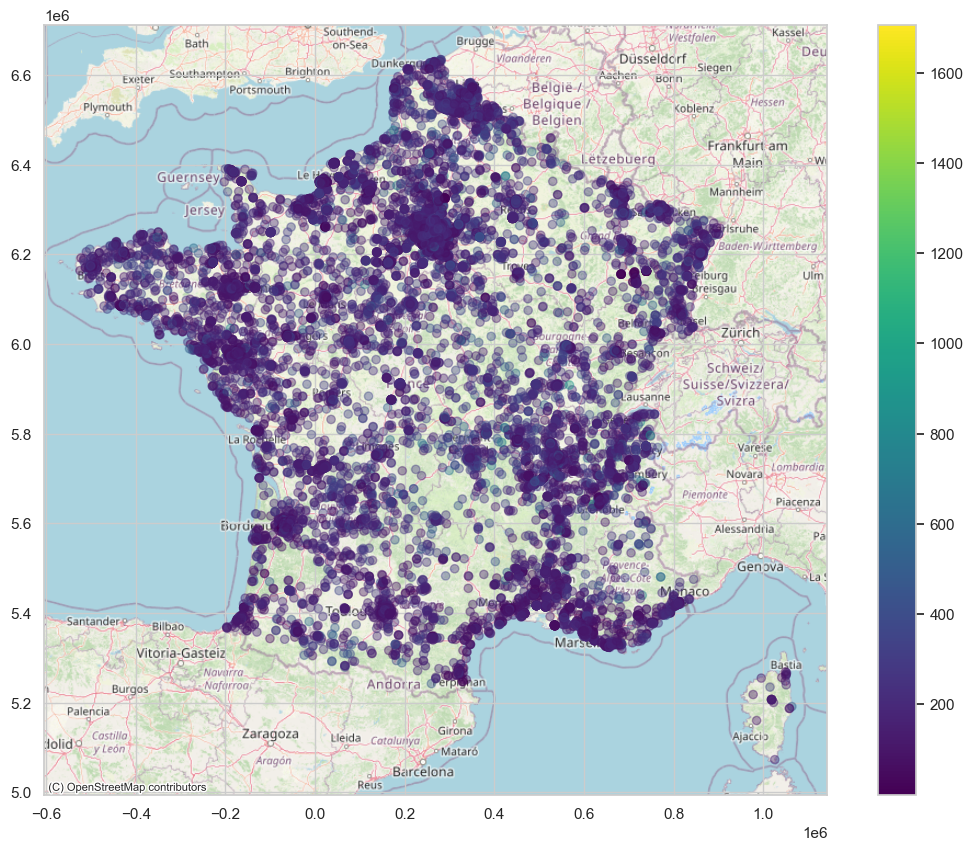

In [114]:
# Visualisations rapides des données sur une carte de la France 

# Carte de la France avec légende en fonction d'une variable d'intérêt : 
fig,ax = plt.subplots(figsize=(13, 10))
gdf.to_crs(3857).plot(column ='Conso_5_usages/m²_é_finale',cmap='viridis',ax=ax ,alpha = 0.4, zorder=2, legend = True)

#shp_communes.to_crs(3857).plot(ax = ax, zorder=1, edgecolor = "black", facecolor="none", color = None)
ctx.add_basemap(ax, source = ctx.providers.OpenStreetMap.Mapnik) # fond de carte

***Les données dont nous disposons indiquent une consommation relativement uniforme en France par mètre carré, avec des valeurs généralement inférieures à 1000. Toutefois, il est important de noter une disparité dans la répartition des logements sur la carte de la France. Cette disparité s'explique en grande partie par la différence de densité de population entre les régions, certaines étant nettement moins peuplées que d'autres.***

In [115]:
'''
Source du fichier : https://france-geojson.gregoiredavid.fr 
Cartes des régions, départements, arrondissements, cantons et communes de France (métropole et départements d'outre-mer) 
à partir des données publiées par l'IGN et l'INSEE.
'''

deps = gpd.read_file('DATA/departements.geojson')
deps.head(3)

code       nom                                           geometry
0   02     Aisne  POLYGON ((3.17270 50.01200, 3.18220 50.01234, ...
1   10      Aube  POLYGON ((3.41479 48.39027, 3.42208 48.41334, ...
2   14  Calvados  POLYGON ((-1.11962 49.35557, -1.11503 49.36240...

In [116]:
# On effectue une jointure entre nos departements récupérés et notre base de donnée : 

gdf_dep = deps.merge(gdf, left_on = 'code', right_on = 'N°_département_(BAN)')
gdf_dep.head(2)

code    nom                                         geometry_x  \
0   02  Aisne  POLYGON ((3.17270 50.01200, 3.18220 50.01234, ...   
1   02  Aisne  POLYGON ((3.17270 50.01200, 3.18220 50.01234, ...   

  Type_énergie_n°1  Coût_total_5_usages_énergie_n°2 Type_énergie_n°2  \
0      Gaz naturel                            408.7              GPL   
1    Bois – Bûches                           5523.8      Électricité   

  Nom__commune_(BAN) Qualité_isolation_enveloppe  Coût_total_5_usages  \
0               Laon                insuffisante                998.4   
1             Chauny                insuffisante               5523.8   

   Emission_GES_5_usages  ... Hauteur_sous-plafond Surface_habitable_logement  \
0                 1771.7  ...                  2.5                       33.5   
1                13693.0  ...                  2.8                      321.1   

  Coordonnée_cartographique_Y_(BAN) Période_construction  \
0                        6940510.38            1975-1977   
1                        6946725.90           avant 1948   

       Type_installation_ECS  Zone_climatique_   Classe_altitude  \
0  installation individuelle               H1a  inférieur à 400m   
1  installation individuelle               H1a  inférieur à 400m   

  Type_énergie_principale_ECS Type_énergie_principale_chauffage  \
0                 Gaz naturel                               GPL   
1                 Électricité                       Gaz naturel   

                 geometry_y  
0  POINT (3.63799 49.56218)  
1  POINT (3.22328 49.61950)  

[2 rows x 36 columns]

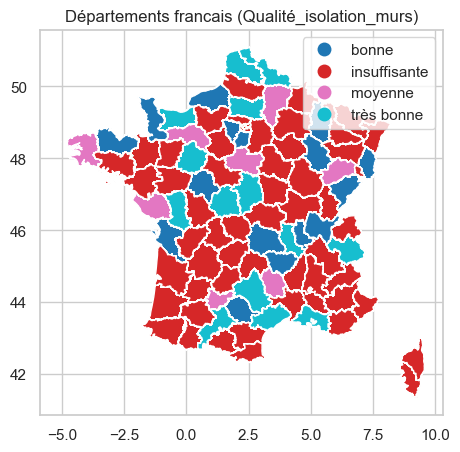

In [121]:

gdf_dep = gpd.GeoDataFrame(gdf_dep, geometry = 'geometry_x')

def Carte_France_departements (geodf,var):
    '''
    args => geodf est un geodataframe avec les polygone des régions en géométries 
         => var : le nom de la varaible d'intéret (numérique) ex : 'Qualité_isolation_murs' ou 'Conso_5_usages/m²_é_finale'
    '''
    geodf.plot(figsize = (7,5), column = var, legend = True)
    plt.title(f"Départements francais ({var})")

Carte_France_departements(gdf_dep,'Qualité_isolation_murs' )

***En ce qui concerne l'isolation des murs des logements de notre base de données, une observation notable révèle que les logements situés dans les zones moins densément peuplées présentent une isolation moins efficace. Cette tendance peut s'expliquer par le fait que dans les grandes villes, les logements sont généralement plus récents, répondant ainsi aux normes actuelles d'isolation. En revanche, dans les zones plus rurales, les logements tendent à être plus anciens, ce qui se traduit par des niveaux d'isolation moins performants.***

-----------------------------
    => Etape 2 : on se focalise à présent que sur les logements de la région parisienne (Paris intramusros plus petite couronne)

In [122]:
# analyse et représentations cartographiques
shp_communes = s3.download_vectorfile_url_all(
    crs = 4326,
    values = ["75", "92", "93", "94"],
    borders="COMMUNE_ARRONDISSEMENT",
    vectorfile_format="topojson",
    filter_by="DEPARTEMENT",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022)

https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=COMMUNE_ARRONDISSEMENT/crs=4326/DEPARTEMENT=75/vectorfile_format=topojson/provider=IGN/source=EXPRESS-COG-CARTO-TERRITOIRE/raw.topojson


Downloading: : 40.1kiB [00:00, 9.13MiB/s]


https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=COMMUNE_ARRONDISSEMENT/crs=4326/DEPARTEMENT=92/vectorfile_format=topojson/provider=IGN/source=EXPRESS-COG-CARTO-TERRITOIRE/raw.topojson


Downloading: : 63.0kiB [00:00, 15.2MiB/s]


https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=COMMUNE_ARRONDISSEMENT/crs=4326/DEPARTEMENT=93/vectorfile_format=topojson/provider=IGN/source=EXPRESS-COG-CARTO-TERRITOIRE/raw.topojson


Downloading: : 120kiB [00:00, 8.59MiB/s]


https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=COMMUNE_ARRONDISSEMENT/crs=4326/DEPARTEMENT=94/vectorfile_format=topojson/provider=IGN/source=EXPRESS-COG-CARTO-TERRITOIRE/raw.topojson


Downloading: : 111kiB [00:00, 10.0MiB/s]


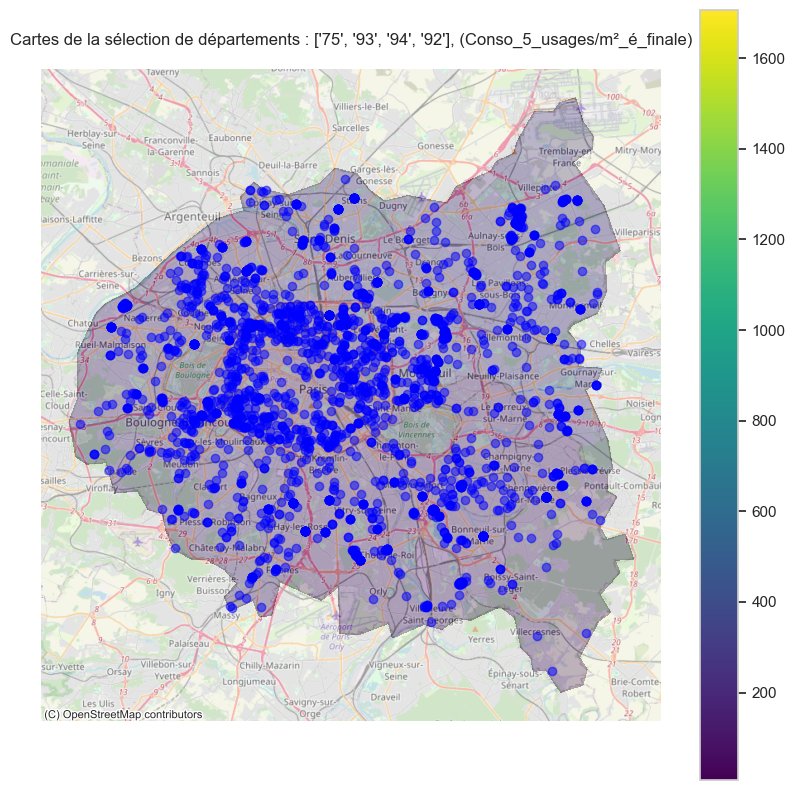

In [124]:

def carte_selection_dep (gdf_dep, values, selected_var = 'Conso_5_usages/m²_é_finale') : 
    '''
    returne
    '''
    gdf_zone = gdf_dep[gdf_dep['code'].isin(values)]

    sorted(gdf_zone['code'].unique())
    fig, ax = plt.subplots ( figsize= (10,10))
    gdf_zone.to_crs(3857).plot(ax=ax, zorder=1 ,column = selected_var, legend = True, edgecolor = "black", linewidth=0.5,  cmap= 'viridis')
    gdf_zone['geometry_y'].to_crs(3857).plot(ax =ax, color = 'blue',alpha = 0.5, zorder=3)

    #shp_communes.to_crs(3857).boundary.plot(ax=ax, zorder=1 , edgecolor = "black", linewidth=0.5, facecolor="none",color = None)
    ctx.add_basemap(ax, source = ctx.providers.OpenStreetMap.Mapnik, zorder=2, alpha = 0.7)
    ax.set_axis_off()
    plt.title(f'Cartes de la sélection de départements : {values}, ({selected_var})' ) 

values = ['75','93','94','92']
carte_selection_dep (gdf_dep, values)

---------------------------------------
    => ETAPE 3 : REPRESENTATION DES REGIONS AVEC DECOUPAGE EN DEPARTEMENT

In [125]:
code_regions_france = pd.read_csv('DATA/code_region_france.csv', delimiter = ';')
code_regions_france['REG'] = code_regions_france['REG'].astype(str)

gdf = gdf.merge(code_regions_france, left_on='N°_région_(BAN)', right_on='REG')

In [126]:
gdf = deps.merge(gdf, left_on = 'code', right_on = 'N°_département_(BAN)')
gdf = gpd.GeoDataFrame(gdf, geometry = 'geometry_x')

https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=COMMUNE_ARRONDISSEMENT/crs=4326/DEPARTEMENT=40/vectorfile_format=topojson/provider=IGN/source=EXPRESS-COG-CARTO-TERRITOIRE/raw.topojson


Downloading: : 1.12MiB [00:00, 14.9MiB/s]


https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=COMMUNE_ARRONDISSEMENT/crs=4326/DEPARTEMENT=47/vectorfile_format=topojson/provider=IGN/source=EXPRESS-COG-CARTO-TERRITOIRE/raw.topojson


Downloading: : 1.28MiB [00:00, 16.2MiB/s]


https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=COMMUNE_ARRONDISSEMENT/crs=4326/DEPARTEMENT=17/vectorfile_format=topojson/provider=IGN/source=EXPRESS-COG-CARTO-TERRITOIRE/raw.topojson


Downloading: : 1.79MiB [00:00, 16.5MiB/s]


https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=COMMUNE_ARRONDISSEMENT/crs=4326/DEPARTEMENT=19/vectorfile_format=topojson/provider=IGN/source=EXPRESS-COG-CARTO-TERRITOIRE/raw.topojson


Downloading: : 1.37MiB [00:00, 16.7MiB/s]


https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=COMMUNE_ARRONDISSEMENT/crs=4326/DEPARTEMENT=24/vectorfile_format=topojson/provider=IGN/source=EXPRESS-COG-CARTO-TERRITOIRE/raw.topojson


Downloading: : 1.50MiB [00:00, 16.9MiB/s]


https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=COMMUNE_ARRONDISSEMENT/crs=4326/DEPARTEMENT=64/vectorfile_format=topojson/provider=IGN/source=EXPRESS-COG-CARTO-TERRITOIRE/raw.topojson


Downloading: : 1.93MiB [00:00, 13.7MiB/s]


https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=COMMUNE_ARRONDISSEMENT/crs=4326/DEPARTEMENT=87/vectorfile_format=topojson/provider=IGN/source=EXPRESS-COG-CARTO-TERRITOIRE/raw.topojson


Downloading: : 1.08MiB [00:00, 11.4MiB/s]


https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=COMMUNE_ARRONDISSEMENT/crs=4326/DEPARTEMENT=23/vectorfile_format=topojson/provider=IGN/source=EXPRESS-COG-CARTO-TERRITOIRE/raw.topojson


Downloading: : 1.19MiB [00:00, 14.2MiB/s]


https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=COMMUNE_ARRONDISSEMENT/crs=4326/DEPARTEMENT=33/vectorfile_format=topojson/provider=IGN/source=EXPRESS-COG-CARTO-TERRITOIRE/raw.topojson


Downloading: : 1.47MiB [00:00, 19.3MiB/s]


https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=COMMUNE_ARRONDISSEMENT/crs=4326/DEPARTEMENT=86/vectorfile_format=topojson/provider=IGN/source=EXPRESS-COG-CARTO-TERRITOIRE/raw.topojson


Downloading: : 1.00MiB [00:00, 10.8MiB/s]


https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=COMMUNE_ARRONDISSEMENT/crs=4326/DEPARTEMENT=16/vectorfile_format=topojson/provider=IGN/source=EXPRESS-COG-CARTO-TERRITOIRE/raw.topojson


Downloading: : 1.29MiB [00:00, 5.86MiB/s]


https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=COMMUNE_ARRONDISSEMENT/crs=4326/DEPARTEMENT=79/vectorfile_format=topojson/provider=IGN/source=EXPRESS-COG-CARTO-TERRITOIRE/raw.topojson


Downloading: : 1.27MiB [00:00, 8.47MiB/s]


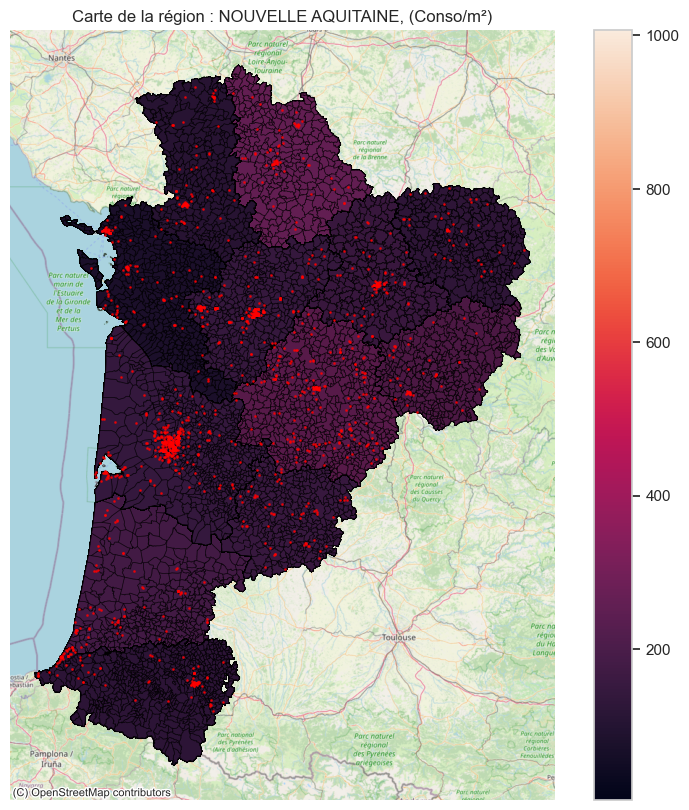

In [127]:
# L'objectif c'est de pouvoir faire une fonction qui nous affiche les logements selon la région que l'on indique : 
# 1° on indique la région : exemple (ile de france)
# 2° a partir de cette region on récupere la liste des département qui la compose ( .unique())
# 3° On plot les point et les tracé des département 
# 4° on plot une carte interactive. 
def carte_region (gdf, region_choisie, var='Conso_5_usages/m²_é_finale'):
    ''' /!\ le gdf doit contenir - les noms de regions
                                 - les numéros de département et leurs géométrie
    '''
    gdf_region = gdf[gdf['Nom_reg']== region_choisie]
    shp_communes = s3.download_vectorfile_url_all(
        crs = 4326,
        values = gdf_region['code'].unique(), #on obtiens tous les codes des département de la régions selectionnée
        borders="COMMUNE_ARRONDISSEMENT",
        vectorfile_format="topojson",
        filter_by="DEPARTEMENT",
        source="EXPRESS-COG-CARTO-TERRITOIRE",
        year=2022)

    #values = gdf['code'].unique()   on obtiens tous les codes des département de la régions selectionnée
    #gdf_paris = gdf_dep[gdf_dep['code'].isin(gdf['code'].unique())]

    #sorted(gdf_paris['code'].unique())
    #gdf_paris
    fig, ax = plt.subplots ( figsize= (10,10))
    gdf_region.to_crs(3857).plot(ax=ax ,column = 'Conso_5_usages/m²_é_finale', legend = True, edgecolor = "black", linewidth=0.5, zorder=2, alpha=0.5)
    gdf_region['geometry_y'].to_crs(3857).plot(ax =ax, marker='o', markersize=1, alpha=0.7,color = 'red', zorder=4)

    shp_communes.to_crs(3857).boundary.plot(ax=ax, zorder=3 , edgecolor = "black", linewidth=0.5, facecolor="none",color = None, alpha=0.5)
    ctx.add_basemap(ax, source = ctx.providers.OpenStreetMap.Mapnik, zorder=1, alpha = 1)
    plt.title (f"Carte de la région : {region_choisie}, (Conso/m²)")
    ax.set_axis_off()

#test    
region_choisie = np.random.choice(gdf['Nom_reg'].unique())
carte_region(gdf, region_choisie)

Il est à noter que le niveau de nos variables d'intérêt varie considérablement en fonction des régions observées, ce qui est en cohérence avec les résultats précédemment obtenus.

## Traitement des variables catégorielles

In [128]:
df_pred = df.drop(['Nom__commune_(BAN)',
                  'Coordonnée_cartographique_X_(BAN)',     
                  'Coordonnée_cartographique_Y_(BAN)',
                  'Année_construction'], axis =1)

In [129]:
df_pred.columns

Index(['Type_énergie_n°1', 'Coût_total_5_usages_énergie_n°2',
       'Type_énergie_n°2', 'Qualité_isolation_enveloppe',
       'Coût_total_5_usages', 'Emission_GES_5_usages', 'N°DPE',
       'Qualité_isolation_menuiseries', 'Qualité_isolation_murs',
       'Etiquette_GES', 'Conso_5_usages_é_finale_énergie_n°1',
       'Conso_chauffage_é_finale', 'Type_bâtiment', 'Etiquette_DPE',
       'Emission_GES_5_usages_par_m²', 'Conso_5_usages_é_finale',
       'N°_département_(BAN)', 'N°_région_(BAN)',
       'Qualité_isolation_plancher_bas', 'Conso_5_usages/m²_é_finale',
       'Hauteur_sous-plafond', 'Surface_habitable_logement',
       'Période_construction', 'Type_installation_ECS', 'Zone_climatique_',
       'Classe_altitude', 'Type_énergie_principale_ECS',
       'Type_énergie_principale_chauffage'],
      dtype='object')

In [130]:
df_pred.dropna(axis=0, how='any', inplace=True)

In [131]:
df_pred.shape

(92283, 28)

In [132]:
categorical_variables = ['Type_énergie_n°1',       # 11 valeurs uniques
                  'Type_énergie_n°2',              # 8 valeurs uniques
                  'Etiquette_GES',
                  'Etiquette_DPE',                 # 7 valeurs uniques
                  'Type_bâtiment',                 # 3 valeurs uniques
                  'Période_construction',          # 10 valeurs uniques
                  'Classe_altitude',               # 3 valeurs uniques
                  'Zone_climatique_',              # 8 valeurs uniques 
                  'Qualité_isolation_enveloppe',    # 4 valeurs uniques 
                  'Qualité_isolation_menuiseries',  # 4 valeurs uniques 
                  'Qualité_isolation_murs',         # 4 valeurs uniques 
                  'Qualité_isolation_plancher_bas', # 4 valeurs uniques 
                  'Type_énergie_principale_chauffage', # 11 valeurs uniques
                  'Type_installation_ECS',           # 3 valeurs uniques
                  ]    

On explore en détail les variables qui prennent plusieurs valeurs uniques, cela nous aide à trouver un moyen pour les encoder et réduire la complexité du modèle.

In [133]:
categorical_variables1 = ['Type_énergie_n°1',       # 11 valeurs uniques
                  'Type_énergie_n°2',              # 8 valeurs uniques
                  'Type_énergie_principale_chauffage', # 11 valeurs uniques
                    ]

In [134]:
df_pred['Type_énergie_n°2'].value_counts()

Type_énergie_n°2
Électricité                                                     72034
Gaz naturel                                                      9945
Bois – Bûches                                                    5564
Fioul domestique                                                 1414
Réseau de Chauffage urbain                                       1119
Bois – Granulés (pellets) ou briquettes                          1080
Électricité d'origine renouvelable utilisée dans le bâtiment      672
GPL                                                               425
Bois – Plaquettes forestières                                      15
Charbon                                                             8
Propane                                                             3
Butane                                                              3
Bois – Plaquettes d’industrie                                       1
Name: count, dtype: int64

On remarque que certaines sources d’énergie sont surreprésentées (Electricité, Bois – Bûches  et Gaz naturel), nous allons donc garder ces trois catégories, et on créera deux autres catégories: la première contient le Fioul Domestique et le GPL comme étant les sources les plus polluantes, et la deuxième regroupe l’électricité d’origine renouvelable et le réseau de chauffage urbain. Nous allons faire de même avec le type d’énergie 1 et l’énergie utilisée pour le chauffage.

In [135]:
# Encodage de la variable 'Type_énergie_n°2'

df_pred['Type_énergie_n°2'] = df_pred['Type_énergie_n°2'].replace(['Bois – Bûches','Bois – Granulés (pellets) ou briquettes'], 'Bois')

df_pred['Type_énergie_n°2'] = df['Type_énergie_n°2'].replace(["Électricité d'origine renouvelable utilisée dans le bâtiment",'Réseau de Chauffage urbain'], 'Énergies propres')

df_pred['Type_énergie_n°2'] = df_pred['Type_énergie_n°2'].replace(["Fioul domestique",'GPL','Charbon','Butane','Propane'], 'Énergies polluantes')


In [136]:
df_pred['Type_énergie_n°1'].value_counts()

Type_énergie_n°1
Gaz naturel                                                     46249
Réseau de Chauffage urbain                                      19302
Électricité                                                     14375
Fioul domestique                                                 4126
GPL                                                              3702
Bois – Bûches                                                    3089
Bois – Granulés (pellets) ou briquettes                          1069
Électricité d'origine renouvelable utilisée dans le bâtiment      154
Bois – Plaquettes forestières                                      88
Bois – Plaquettes d’industrie                                      84
Charbon                                                            29
Propane                                                            16
Name: count, dtype: int64

In [137]:
# Encodage de la variable 'Type_énergie_n°1'

df_pred['Type_énergie_n°1'] = df_pred['Type_énergie_n°1'].replace(['Bois – Bûches','Bois – Granulés (pellets) ou briquettes', 'Bois – Plaquettes d’industrie', 'Bois – Plaquettes forestières'], 'Bois')

df_pred['Type_énergie_n°1'] = df_pred['Type_énergie_n°1'].replace(["Électricité d'origine renouvelable utilisée dans le bâtiment",'Réseau de Chauffage urbain','Réseau de Froid Urbain'], 'Énergies propres')

df_pred['Type_énergie_n°1'] = df_pred['Type_énergie_n°1'].replace(["Fioul domestique",'GPL','Propane','Charbon','Butane'], 'Énergies polluantes')

In [138]:
df_pred['Type_énergie_principale_chauffage'].value_counts()

Type_énergie_principale_chauffage
Gaz naturel                                                     51341
Réseau de Chauffage urbain                                      20336
Électricité                                                      7814
Fioul domestique                                                 5370
GPL                                                              3865
Bois – Bûches                                                    2222
Bois – Granulés (pellets) ou briquettes                          1039
Bois – Plaquettes forestières                                      88
Bois – Plaquettes d’industrie                                      84
Propane                                                            57
Électricité d'origine renouvelable utilisée dans le bâtiment       35
Charbon                                                            32
Name: count, dtype: int64

In [139]:
# Encodage de la variable 'Type_énergie_principale_chauffage'

df_pred['Type_énergie_principale_chauffage'] = df_pred['Type_énergie_principale_chauffage'].replace(['Bois – Bûches','Bois – Granulés (pellets) ou briquettes', 'Bois – Plaquettes d’industrie', 'Bois – Plaquettes forestières'], 'Bois')

df_pred['Type_énergie_principale_chauffage'] = df_pred['Type_énergie_principale_chauffage'].replace(["Fioul domestique",'GPL','Propane','Charbon','Butane'], 'Énergies polluantes')

df_pred['Type_énergie_principale_chauffage'] = df_pred['Type_énergie_principale_chauffage'].replace(["Électricité d'origine renouvelable utilisée dans le bâtiment",'Réseau de Chauffage urbain','Réseau de Froid Urbain'], 'Énergies propres')

In [152]:
# Encodage de la variable 'Type_énergie_principale_ECS'

df_pred['Type_énergie_principale_ECS'] = df_pred['Type_énergie_principale_ECS'].replace(['Bois – Bûches','Bois – Granulés (pellets) ou briquettes', 'Bois – Plaquettes d’industrie', 'Bois – Plaquettes forestières'], 'Bois')

df_pred['Type_énergie_principale_ECS'] = df_pred['Type_énergie_principale_ECS'].replace(["Fioul domestique",'GPL','Propane','Charbon','Butane'], 'Énergies polluantes')

df_pred['Type_énergie_principale_ECS'] = df_pred['Type_énergie_principale_ECS'].replace(["Électricité d'origine renouvelable utilisée dans le bâtiment",'Réseau de Chauffage urbain','Réseau de Froid Urbain'], 'Énergies propres')

## Exploration des variables continues et traitement des valeurs aberrantes

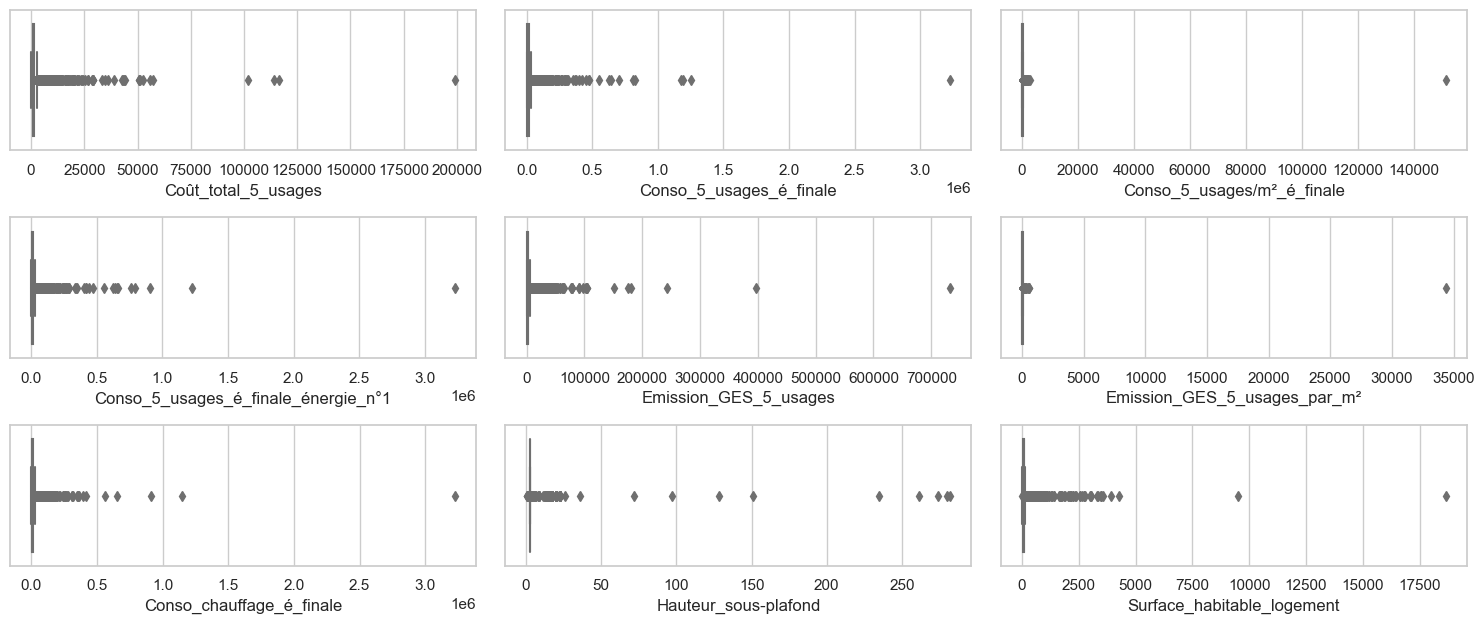

In [140]:
continuous_variables =['Coût_total_5_usages','Conso_5_usages_é_finale','Conso_5_usages/m²_é_finale','Conso_5_usages_é_finale_énergie_n°1', 'Emission_GES_5_usages','Emission_GES_5_usages_par_m²','Conso_chauffage_é_finale','Hauteur_sous-plafond','Surface_habitable_logement']

eda.boxplot(df_pred,continuous_variables)

On remarque que toutes les variables contiennent des valeurs aberrantes très élevées par rapport aux autres valeurs, cela risque d’impacter la modélisation, mais on ne va pas les supprimer puisqu’il s’agit bien des logements existants, et leur suppression conduit à une sous-estimation de la consommation de la consommation et du volume des émissions dans certains logements. On va alors remplacer les valeurs très élevées par (q3 + 3.5 * iqr) et les valeurs très faibles par (q3 - 3.5 * iqr) avec q1 et q3 sont le premier et le troisième quantile, et iqr est la différence entre les deux.

In [141]:
# Détection du nombre des valeurs aberrantes par la méthode des quantiles

eda.Outliers(df_pred,continuous_variables)

variable nombre_val_aberrantes
0                  Coût_total_5_usages                  1425
0              Conso_5_usages_é_finale                  1425
0           Conso_5_usages/m²_é_finale                   345
0  Conso_5_usages_é_finale_énergie_n°1                  1460
0                Emission_GES_5_usages                  1762
0         Emission_GES_5_usages_par_m²                   295
0             Conso_chauffage_é_finale                  1594
0                 Hauteur_sous-plafond                 16815
0           Surface_habitable_logement                  1774

In [142]:
df_pred["Hauteur_sous-plafond"].describe()

count    92283.000000
mean         2.571036
std          2.152471
min          0.400000
25%          2.500000
50%          2.500000
75%          2.500000
max        282.000000
Name: Hauteur_sous-plafond, dtype: float64

On remarque que toutes les variables contiennent des valeurs aberrantes très élevées par rapport aux autres valeurs, cela risque d’impacter la modélisation, mais on ne va pas les supprimer puisqu’il s’agit bien des logements existants, et leur suppression conduit à une sous-estimation de la consommation de la consommation et du volume des émissions dans certains logements. On va alors remplacer les valeurs très élevées par (q3 + 3.5 * iqr) et les valeurs très faibles par (q3 - 3.5 * iqr) avec q1 et q3 sont le premier et le troisième quantile, et iqr est la différence entre les deux.

In [143]:
df_pred = eda.remplacer_outliers(df_pred,continuous_variables)

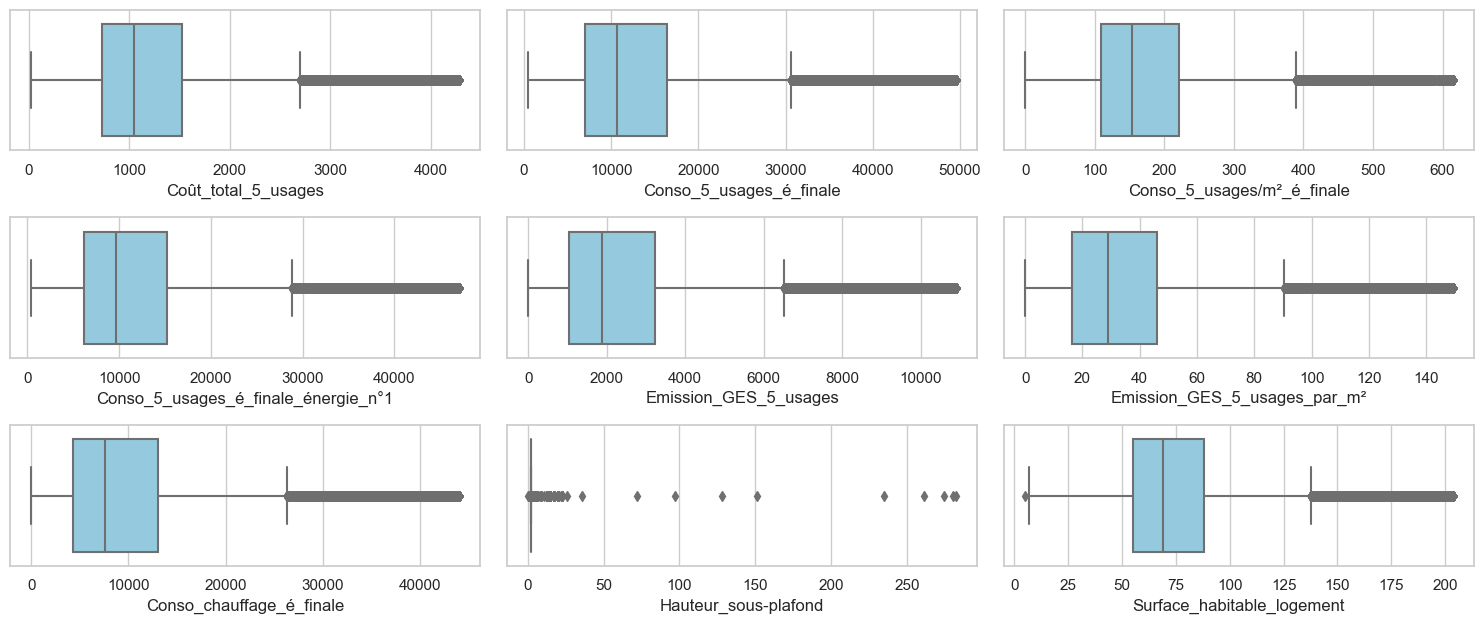

In [144]:
eda.boxplot(df_pred,continuous_variables)

On choisit de prédire directement la consommation de l’énergie et le volume des émissions par m² puisque ces deux variables contiennent le minimum de valeurs aberrantes. Les variables explicatives continues sont la surface du logement, la hauteur sous plafond et le coût de la consommation totale de l’énergie.

In [145]:
# Standardisation des variables  explicatives continues

scaler = StandardScaler()
continuous_explicative = ["Surface_habitable_logement","Hauteur_sous-plafond" ,'Coût_total_5_usages']
df_pred[continuous_explicative] = scaler.fit_transform(df_pred[continuous_explicative])

In [146]:
# Corrélation entre les variables continues 

corr = df_pred.loc[:,["Surface_habitable_logement","Hauteur_sous-plafond","Conso_5_usages/m²_é_finale","Emission_GES_5_usages_par_m²",'Coût_total_5_usages']].corr()
corr.style.background_gradient(cmap='coolwarm')

On remarque une forte corrélation positive entre la consommation énergétique et le volume des émissions de gaz à effet de serre.
Ces deux variables ont presque les mêmes corrélations avec les variables explicatives retenus.\
La variable Hauteur_sous_plafond est peu corrélées avec les variables cibles, en plus, le traitement de ses valeurs aberrantes nous pose un problème, on va alors l’exclure de la prédiction.

### Quels sont les types d'énergies utilisées en France ? 

In [147]:
# Analyse descriptive de la base de donnée - types d'énergies (interactif, s'affiche seulement apres le lancement du notebook ) : 

eda.pieplot_chauffage_interact(df_pred)

La répartition des types d'énergies utilisées pour le chauffage et pour les équipements de production d'eau chaude sanitaire (OCS) dans les logements est **fortement similaire** dans nos données. On observe une **utilisation prédominante du gaz naturel**, dépassant les 50% dans les deux cas, suivi par des énergies considérées comme propres, représentant environ 22%. En troisième position, on trouve des énergies non liées aux deux premières catégories, constituant environ 10%. L'électricité se place en quatrième position, représentant moins de 10% dans les deux cas. À noter également l'utilisation d'autres sources d'énergie telles que le bois.

/Users/aminerazig/Desktop/ENSAE 2A/Projet-Python/eda.py:343: UserWarning:

FixedFormatter should only be used together with FixedLocator

/Users/aminerazig/Desktop/ENSAE 2A/Projet-Python/eda.py:348: UserWarning:

FixedFormatter should only be used together with FixedLocator



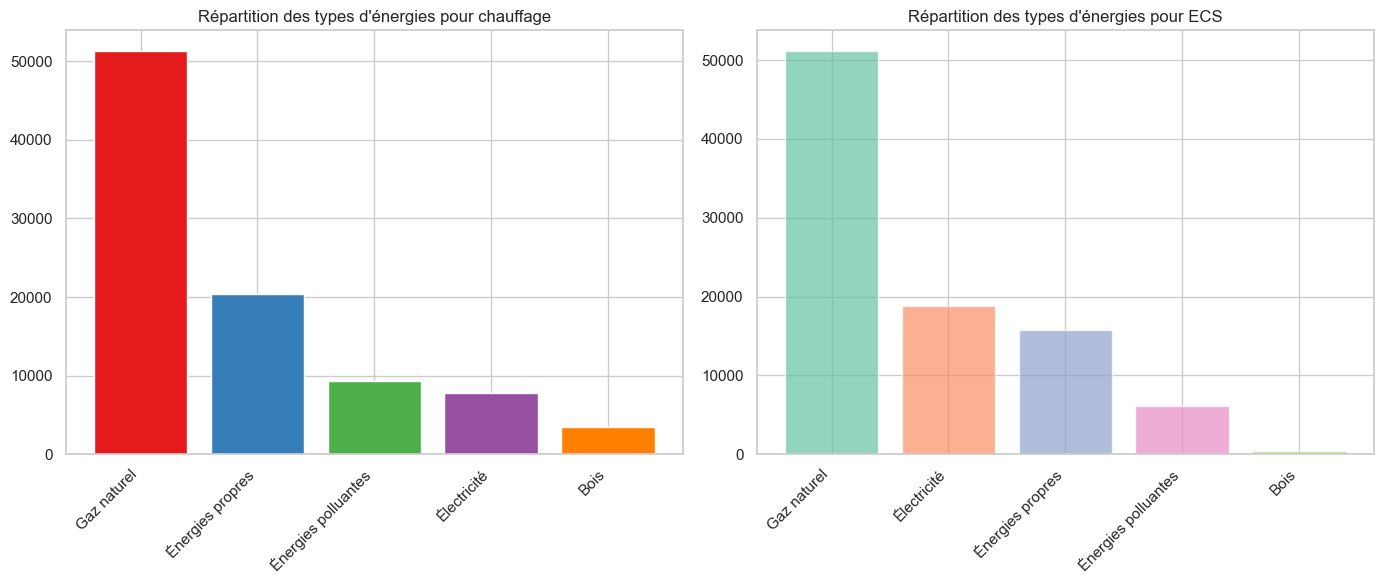

In [153]:
# Barplot fixe types d'energies 

eda.barplot_chauffage(df_pred)

----------------------------------------------------------------------------------------------------
    => Statitiques descriptives géographiques : 

In [154]:
Noms_regions = pd.read_csv("DATA/anciennes-nouvelles-regions.csv", delimiter=';')
Noms_regions['Nouveau Code'] = Noms_regions['Nouveau Code'].astype(str)
df_pred = df_pred.merge(Noms_regions, left_on = 'N°_région_(BAN)', right_on= 'Nouveau Code').drop('Nouveau Code',  axis=1)

/var/folders/85/w86zwk1d6rsg9ct11l1475ww0000gn/T/ipykernel_806/2085219527.py:23: UserWarning:

FixedFormatter should only be used together with FixedLocator

/var/folders/85/w86zwk1d6rsg9ct11l1475ww0000gn/T/ipykernel_806/2085219527.py:32: UserWarning:

FixedFormatter should only be used together with FixedLocator



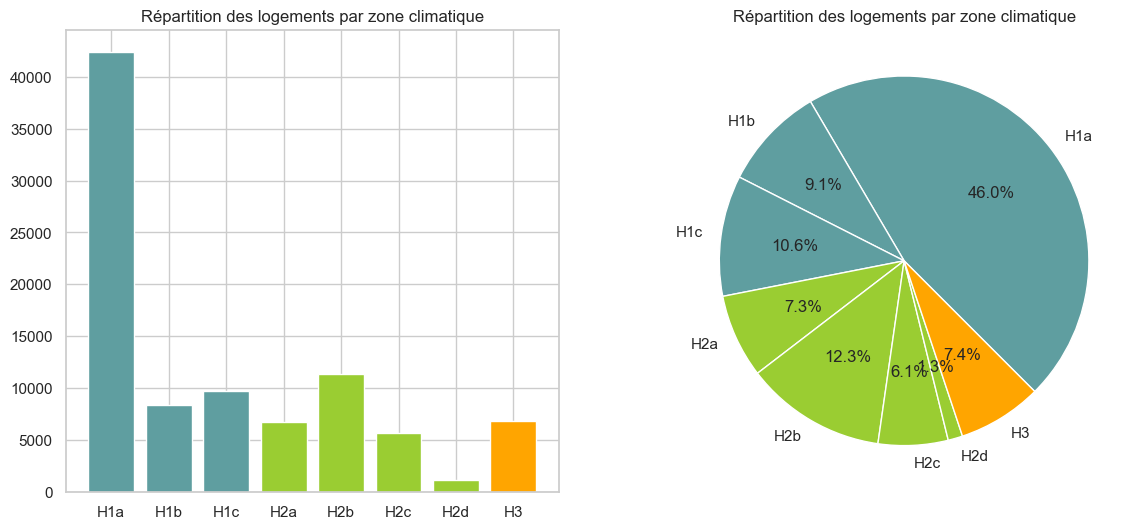

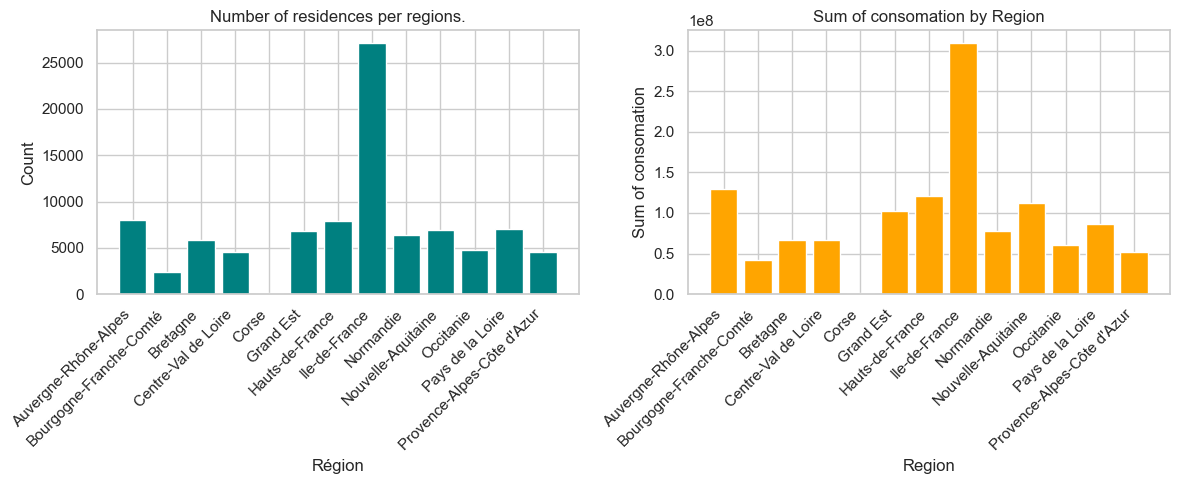

In [155]:
    ####### Répartition des logemenst de la base par zone climatique 
# Création de deux graphiques (en barre et circulaire)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

val = df_pred['Zone_climatique_'].value_counts().sort_index()
colors= 3*['cadetblue'] + 4*['yellowgreen'] + ['orange']


axes[0].bar(val.index, val, color= colors)
axes[0].set_title('Répartition des logements par zone climatique')
explode = (0, 0, 0, 0, 0, 0, 0, 0)
axes[1].pie(x=val, labels=val.index, startangle=-45,colors=colors, autopct='%1.1f%%', explode = explode)
axes[1].set_title('Répartition des logements par zone climatique')


fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    ####### Premier sous-graphique : Répartition des logements par région
val_region = df_pred['Nouveau Nom'].value_counts().sort_index()
axs[0].bar(val_region.index, val_region, color='teal')
axs[0].set_xlabel('Région')
axs[0].set_ylabel('Count')
axs[0].set_title('Number of residences per regions.')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, ha='right')


    ####### Deuxième sous-graphique : Classement des régions par consommation
comptage_conso_region = df_pred.groupby('Nouveau Nom')['Conso_5_usages_é_finale'].sum()
axs[1].bar(comptage_conso_region.index, comptage_conso_region, color='orange')
axs[1].set_xlabel('Region')
axs[1].set_ylabel('Sum of consomation')
axs[1].set_title('Sum of consomation by Region')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45 , ha='right')
plt.tight_layout()
plt.show()

    

Un des points saillants observés dans ces graphiques réside dans la **disproportion considérable des données de logement selon les régions**. En particulier, l'Île-de-France présente un nombre de logements très élevé, une réalité qui découle de la démographie française. En effet, cette concentration importante de logements en Île-de-France reflète la distribution démographique de la population française, avec une concentration significative dans les grandes villes et une présence limitée dans les zones rurales.

### Encodage ordinal pour les variables représentant une hiérarchie naturelle entre les différentes valeurs
Pour les qualités d’isolation, on crée une variable qui prend 0 si l’isolation est insuffisante et 3 si elle est très bonne.\
Pour la période de construction aussi, on crée une variable qui prend les valeurs entre 0 et 9, plus le logement est récent, plus le chiffre est élevé.

In [156]:
df_pred["Période_construction"] = df_pred["Période_construction"].map({"avant 1948":0, "1948-1974":1, "1975-1977":2, "1983-1988":3, '2013-2021':4,'1989-2000':5, '2001-2005':6, '2006-2012':7, '1978-1982':8, 'après 2021':9})

df_pred['Qualité_isolation_plancher_bas'] = df_pred["Qualité_isolation_plancher_bas"].map({"très bonne":3, "insuffisante":0, "bonne":2, "moyenne":1})

df_pred["Qualité_isolation_murs"] = df_pred["Qualité_isolation_murs"].map({"très bonne":3, "insuffisante":0, "bonne":2, "moyenne":1})

df_pred['Qualité_isolation_enveloppe'] = df_pred["Qualité_isolation_enveloppe"].map({"très bonne":3, "insuffisante":0, "bonne":2, "moyenne":1})

df_pred["Qualité_isolation_menuiseries"] = df_pred["Qualité_isolation_menuiseries"].map({"très bonne":3, "insuffisante":0, "bonne":2, "moyenne":1})


### OneHotEncoding pour les autres variables catégorielles

In [157]:
categorical_variables2 = ['Type_énergie_n°1',       # 11 valeurs uniques
                  'Type_énergie_n°2',              # 8 valeurs uniques
                  'Type_bâtiment',                 # 3 valeurs uniques
                  'Classe_altitude',               # 3 valeurs uniques
                  'Zone_climatique_',              # 8 valeurs uniques  
                  'Type_énergie_principale_chauffage', # 11 valeurs uniques
                  'Type_installation_ECS']           # 3 valeurs uniques

onehotencoded = eda.one_hot_encode(df_pred,categorical_variables2)

---------------------------------------
    => Focus sur les variables dépendantes

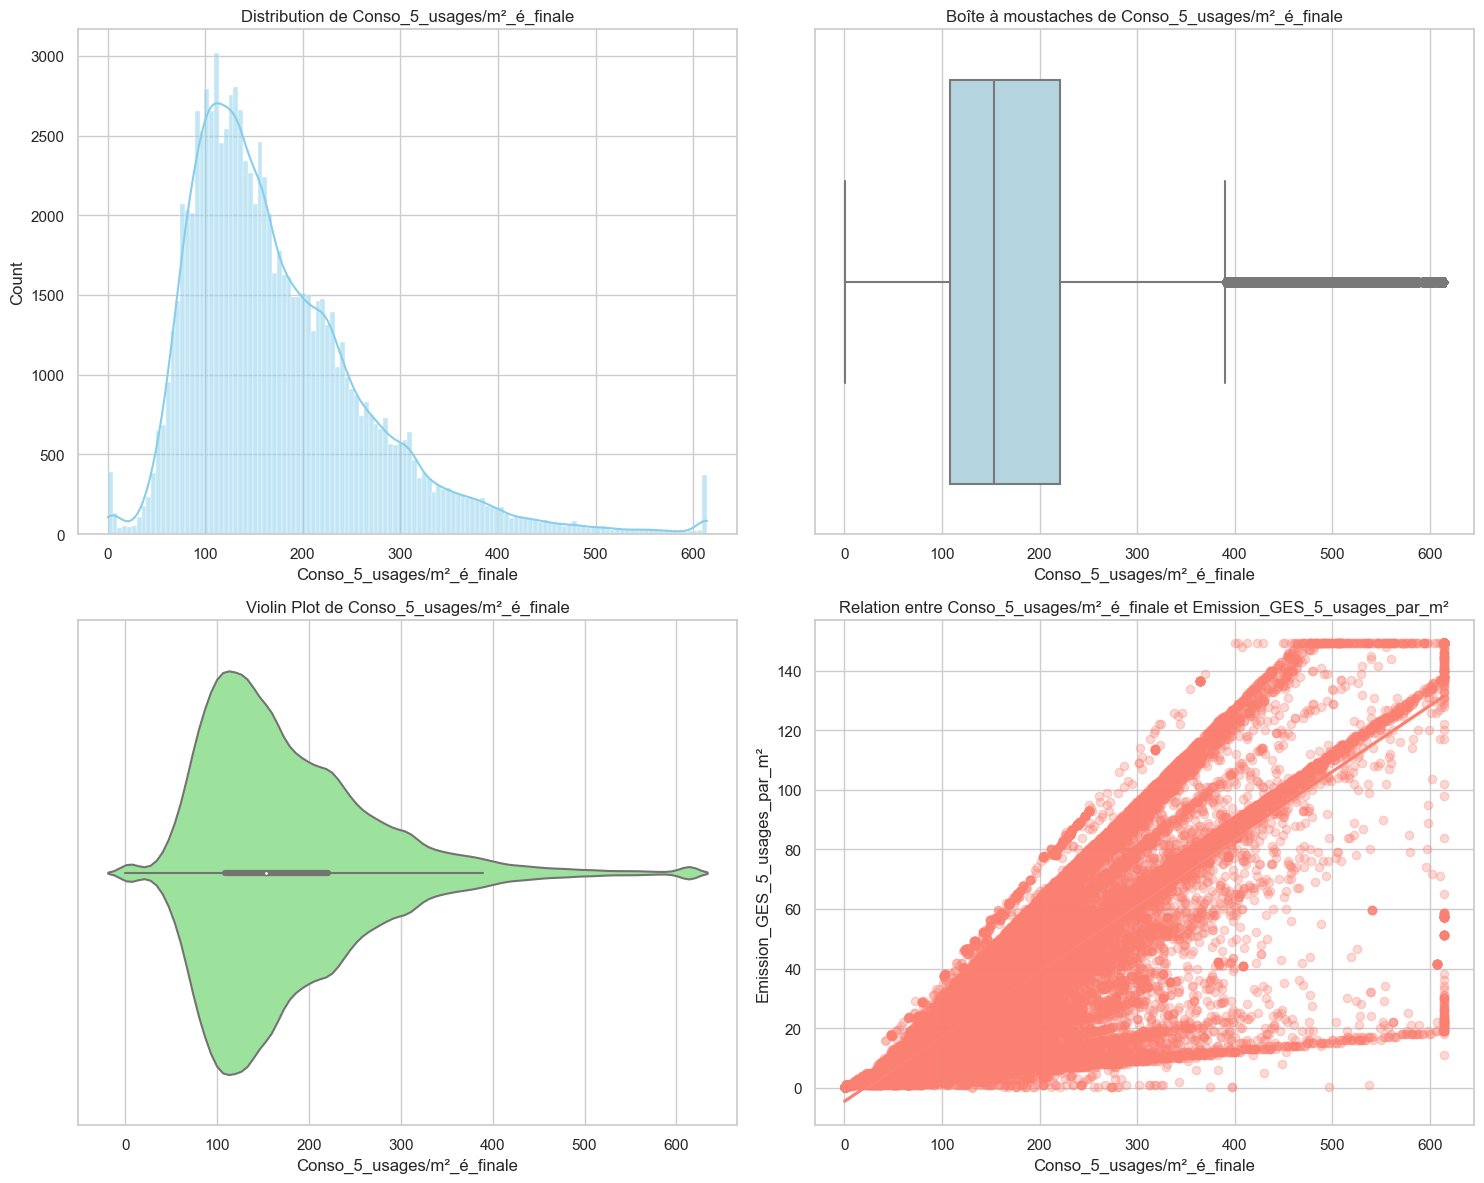

In [158]:
eda.create_energy_plots(df_pred, 'Conso_5_usages/m²_é_finale', 'Emission_GES_5_usages_par_m²')

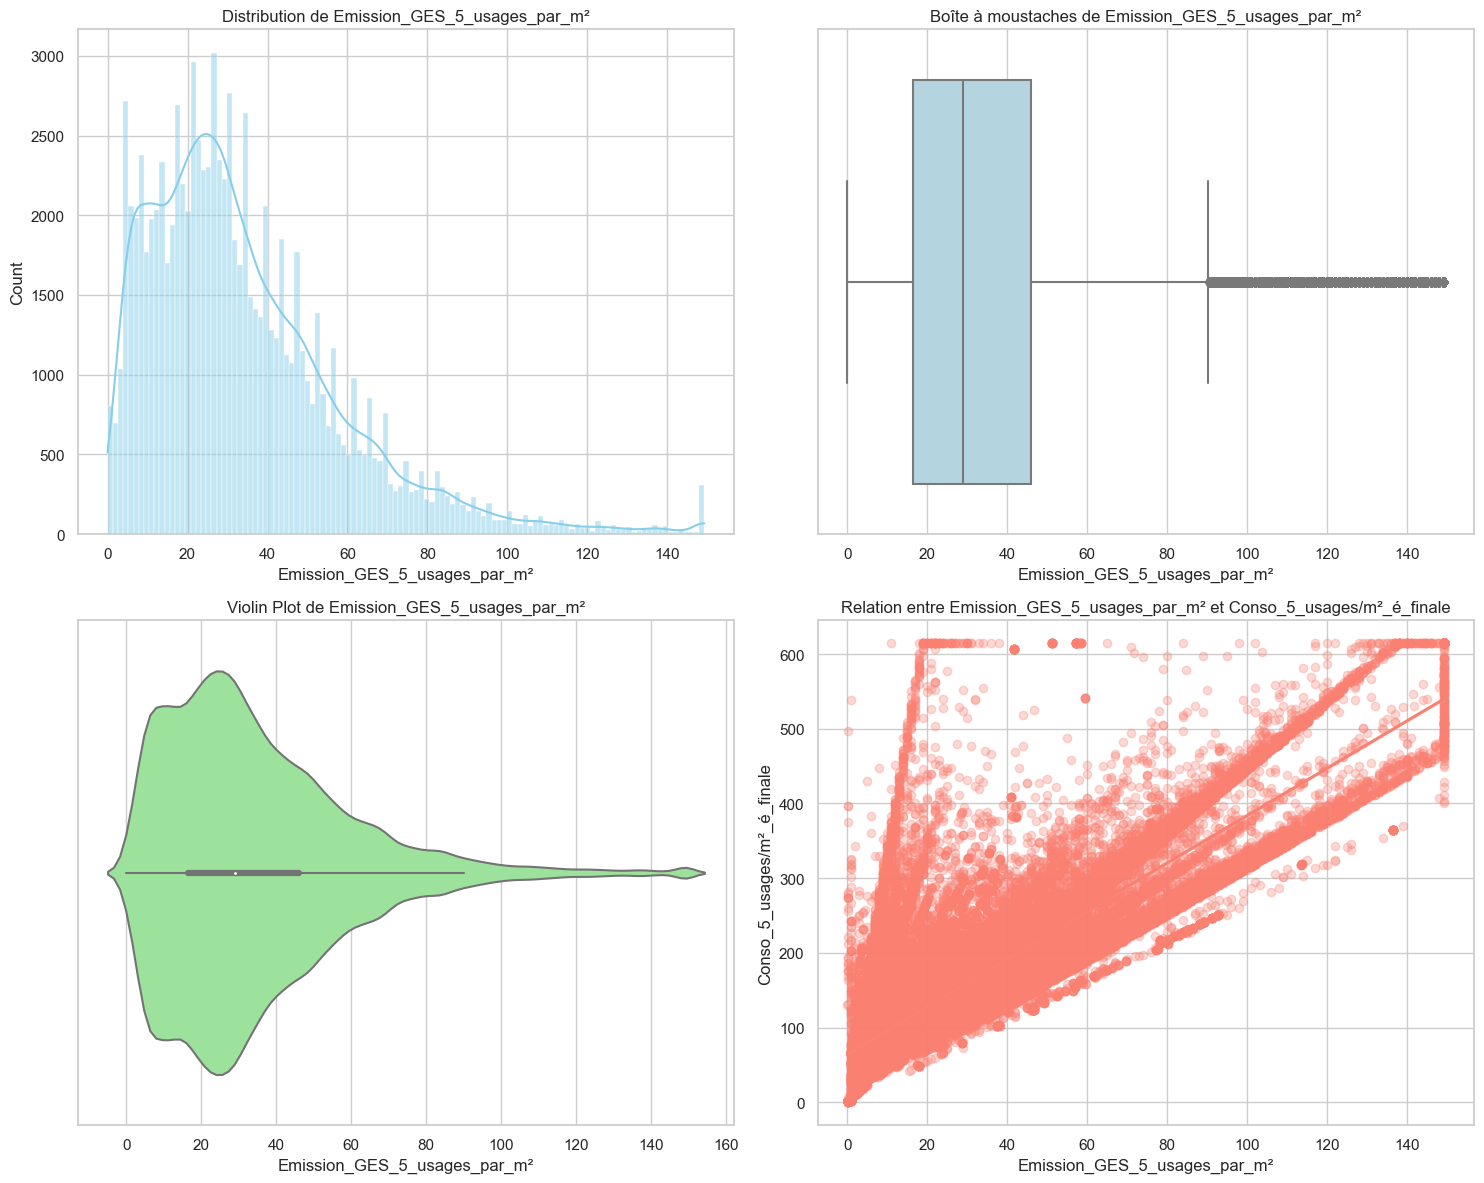

In [159]:
eda.create_energy_plots(df_pred, 'Emission_GES_5_usages_par_m²', 'Conso_5_usages/m²_é_finale')

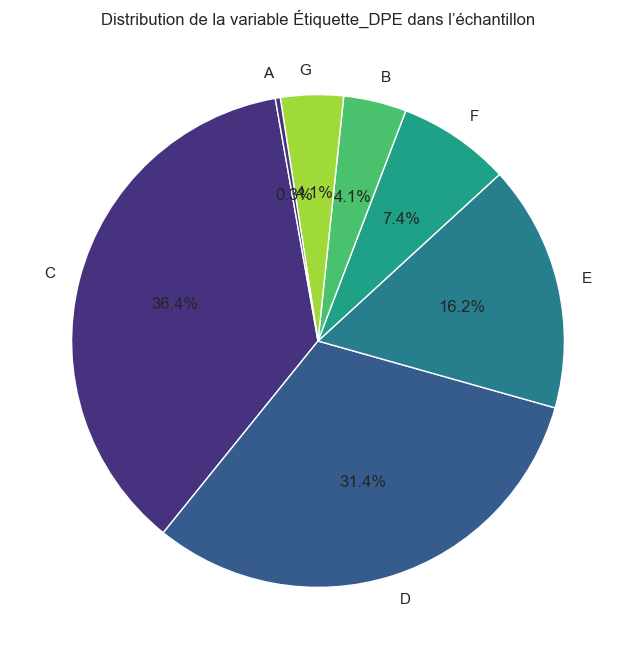

In [172]:
# Distribution des étiquettes DPE 

def visualize_dpe_distribution_pie(dataframe):
    # Calculer les occurrences de chaque catégorie
    occurrences = dataframe['Etiquette_DPE'].value_counts()

    # Définir un thème esthétique pour Seaborn
    sns.set_theme()
    # Créer le graphique circulaire (pie plot) avec Seaborn
    plt.figure(figsize=(8, 8))
    plt.pie(occurrences, labels=occurrences.index, autopct='%1.1f%%', startangle=100, colors=sns.color_palette('viridis'))
    plt.title("Distribution de la variable Étiquette_DPE dans l’échantillon")
    plt.show()

# Utiliser la fonction avec votre DataFrame
visualize_dpe_distribution_pie(df_pred)

Les étiquettes A, B et G sont sous-représentées dans l’échantillon, les valeurs de la consommation et le volume des émissions qui leur sont associées risquent d’être mal predites par le modèle, par contre, on s’attend à une bonne prédiction des étiquettes D, E et C.

### Base de données pour la prédiction

La liste variables_retenues contient les colonnes issues du OneHotEncoding et de l’encodage ordinal des variables ctégorielles ainsi que les variables continues après le traitement de leurs valeurs aberrantes.

In [173]:
variables_retenues = ['Période_construction',
                  'Surface_habitable_logement',
                  'Conso_5_usages/m²_é_finale',
                  'Emission_GES_5_usages_par_m²',
                  'Qualité_isolation_enveloppe',
                  'Qualité_isolation_menuiseries',
                  'Qualité_isolation_murs',
                  'Qualité_isolation_plancher_bas',
                  'Type_énergie_n°1_Gaz naturel',
                  'Type_énergie_n°1_Électricité', 
                  'Type_énergie_n°1_Énergies polluantes',
                  'Type_énergie_n°1_Énergies propres', 
                  'Type_énergie_n°2_Gaz naturel',
                  'Type_énergie_n°2_Électricité', 
                  'Type_énergie_n°2_Énergies polluantes',
                   'Type_énergie_n°2_Énergies propres', 
                   'Type_bâtiment_maison', 
                   'Classe_altitude_inférieur à 400m',
                   'Classe_altitude_supérieur à 800m', 
                   'Zone_climatique__H1b',
                   'Zone_climatique__H1c', 
                   'Zone_climatique__H2a', 
                   'Zone_climatique__H2b',
                   'Zone_climatique__H2c', 
                   'Zone_climatique__H2d', 
                   'Zone_climatique__H3',
                    'Type_énergie_principale_chauffage_Gaz naturel',
                   'Type_énergie_principale_chauffage_Électricité',
                    'Type_énergie_principale_chauffage_Énergies polluantes',
                    'Type_énergie_principale_chauffage_Énergies propres',
                    'Type_installation_ECS_installation collective multi-bâtiment : modélisée comme un réseau de chaleur',
                    'Type_installation_ECS_installation individuelle',
                    'Coût_total_5_usages']

df_finale = onehotencoded.loc[:,variables_retenues]
df_finale.columns

Index(['Période_construction', 'Surface_habitable_logement',
       'Conso_5_usages/m²_é_finale', 'Emission_GES_5_usages_par_m²',
       'Qualité_isolation_enveloppe', 'Qualité_isolation_menuiseries',
       'Qualité_isolation_murs', 'Qualité_isolation_plancher_bas',
       'Type_énergie_n°1_Gaz naturel', 'Type_énergie_n°1_Électricité',
       'Type_énergie_n°1_Énergies polluantes',
       'Type_énergie_n°1_Énergies propres', 'Type_énergie_n°2_Gaz naturel',
       'Type_énergie_n°2_Électricité', 'Type_énergie_n°2_Énergies polluantes',
       'Type_énergie_n°2_Énergies propres', 'Type_bâtiment_maison',
       'Classe_altitude_inférieur à 400m', 'Classe_altitude_supérieur à 800m',
       'Zone_climatique__H1b', 'Zone_climatique__H1c', 'Zone_climatique__H2a',
       'Zone_climatique__H2b', 'Zone_climatique__H2c', 'Zone_climatique__H2d',
       'Zone_climatique__H3', 'Type_énergie_principale_chauffage_Gaz naturel',
       'Type_énergie_principale_chauffage_Électricité',
       'Type_énergi

In [174]:
df_finale.shape

(92275, 33)

In [175]:
df_finale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92275 entries, 0 to 92274
Data columns (total 33 columns):
 #   Column                                                                                               Non-Null Count  Dtype  
---  ------                                                                                               --------------  -----  
 0   Période_construction                                                                                 92275 non-null  int64  
 1   Surface_habitable_logement                                                                           92275 non-null  float64
 2   Conso_5_usages/m²_é_finale                                                                           92275 non-null  float64
 3   Emission_GES_5_usages_par_m²                                                                         92275 non-null  float64
 4   Qualité_isolation_enveloppe                                                                          92275

# Modélisation

Dans ce qui suit, notre objectif est d’attribuer une étiquette DPE au logement en se basant sur ses caractéristaiques. On va d’abord estimer la consommation de l’énergie à partir des différentes variables traitées avant, ensuite, on utilisera les valeurs obtenues pour estimer le volume des émissions des gaz à effet de serre. Finalement, on va déterminer l’étiquette DPE en fonction des valeurs obtenues, la méthode de classification est résumée dans le tableau suivant:



<img src="img.png"  width="1000" height="600">


In [176]:
def remplissage (row):
    
    if row["conso_predite_s"]<70 and row["emission_predite_s"]<6 :
        return "A"
    elif row["conso_predite_s"]<110 and row["emission_predite_s"]<11 :
        return "B"
    elif row["conso_predite_s"]<180 and row["emission_predite_s"]<30 :
        return "C"
    elif row["conso_predite_s"]<250 and row["emission_predite_s"]<50 :
        return "D"
    elif row["conso_predite_s"]<330 and row["emission_predite_s"]<70 :
        return "E"
    elif row["conso_predite_s"]<420 and row["emission_predite_s"]<100 :
        return "F"
    else:
        return "G"

## Prédiction simultanée de la consommation de l’énergie et du volume des émissions de gaz à effet de serre par m² et par an

### Régression Lasso pour sélectionner les variables pertinentes

In [177]:
X_s = df_finale.drop(['Conso_5_usages/m²_é_finale','Emission_GES_5_usages_par_m²'], axis = 'columns')
y_s = df_finale.loc[:,['Conso_5_usages/m²_é_finale','Emission_GES_5_usages_par_m²']]

X_train, X_test, y_train, y_test = train_test_split(X_s, y_s, test_size=0.2, random_state=42)

lasso_cv = MultiTaskLassoCV(alphas=[0.001, 0.01, 0.1, 1, 10], cv=5)  # Spécifiez une liste d'alphas à essayer
lasso_cv.fit(X_train, y_train)

# Afficher l'alpha optimal sélectionné par la validation croisée
best_alpha = lasso_cv.alpha_
print(f"Meilleur alpha : {best_alpha}")

Meilleur alpha : 0.001


In [178]:
alpha = 0.001
lasso_model = sklearn.linear_model.Lasso(alpha)

# Entraînement du modèle sur les données d'entraînement
lasso_model.fit(X_train, y_train)

# Afficher les coefficients non nuls (variables sélectionnées)
model = SelectFromModel(lasso_model, prefit=True).fit(X_train, y_train)

# Affichage des variables sélectionnées par la régression Lasso
model.get_feature_names_out()

array(['Période_construction', 'Surface_habitable_logement',
       'Qualité_isolation_enveloppe', 'Qualité_isolation_menuiseries',
       'Qualité_isolation_murs', 'Qualité_isolation_plancher_bas',
       'Type_énergie_n°1_Gaz naturel', 'Type_énergie_n°1_Électricité',
       'Type_énergie_n°1_Énergies polluantes',
       'Type_énergie_n°1_Énergies propres',
       'Type_énergie_n°2_Gaz naturel', 'Type_énergie_n°2_Électricité',
       'Type_énergie_n°2_Énergies polluantes',
       'Type_énergie_n°2_Énergies propres', 'Type_bâtiment_maison',
       'Classe_altitude_inférieur à 400m',
       'Classe_altitude_supérieur à 800m', 'Zone_climatique__H1b',
       'Zone_climatique__H1c', 'Zone_climatique__H2a',
       'Zone_climatique__H2b', 'Zone_climatique__H2c',
       'Zone_climatique__H2d', 'Zone_climatique__H3',
       'Type_énergie_principale_chauffage_Gaz naturel',
       'Type_énergie_principale_chauffage_Électricité',
       'Type_énergie_principale_chauffage_Énergies polluantes',
   

In [179]:
selected_features = ['Période_construction', 'Surface_habitable_logement',
       'Qualité_isolation_enveloppe', 'Qualité_isolation_menuiseries',
       'Qualité_isolation_murs', 'Qualité_isolation_plancher_bas',
       'Type_énergie_n°1_Gaz naturel', 'Type_énergie_n°1_Électricité',
       'Type_énergie_n°1_Énergies polluantes',
       'Type_énergie_n°1_Énergies propres',
       'Type_énergie_n°2_Gaz naturel', 'Type_énergie_n°2_Électricité',
       'Type_énergie_n°2_Énergies polluantes',
       'Type_énergie_n°2_Énergies propres', 'Type_bâtiment_maison',
       'Classe_altitude_inférieur à 400m',
       'Classe_altitude_supérieur à 800m', 'Zone_climatique__H1b',
       'Zone_climatique__H1c', 'Zone_climatique__H2a',
       'Zone_climatique__H2b', 'Zone_climatique__H2c',
       'Zone_climatique__H2d', 'Zone_climatique__H3',
       'Type_énergie_principale_chauffage_Gaz naturel',
       'Type_énergie_principale_chauffage_Électricité',
       'Type_énergie_principale_chauffage_Énergies polluantes',
       'Type_énergie_principale_chauffage_Énergies propres',
       'Type_installation_ECS_installation collective multi-bâtiment : modélisée comme un réseau de chaleur',
       'Type_installation_ECS_installation individuelle',
       'Coût_total_5_usages']


# Les variables séléctionnées par la régression Lasso lorsqu’on a supprimé les outliers par la méthode IsolationForest
"""
selected_features = ['Période_construction', 'Surface_habitable_logement',
       'Qualité_isolation_enveloppe', 'Qualité_isolation_menuiseries',
       'Qualité_isolation_murs', 'Qualité_isolation_plancher_bas',
       'Type_énergie_n°1_Gaz naturel', 'Type_énergie_n°1_Électricité',
       'Type_énergie_n°1_Énergies polluantes',
       'Type_énergie_n°2_Électricité', 'Type_bâtiment_maison',
       'Classe_altitude_inférieur à 400m', 'Zone_climatique__H1b',
       'Zone_climatique__H1c', 'Zone_climatique__H2a',
       'Zone_climatique__H3',
       'Type_énergie_principale_chauffage_Gaz naturel',
       'Type_énergie_principale_chauffage_Électricité',
       'Type_énergie_principale_chauffage_Énergies polluantes',
       'Type_énergie_principale_chauffage_Énergies propres',
       'Type_installation_ECS_installation individuelle',
       'Coût_total_5_usages'] """

"\nselected_features = ['Période_construction', 'Surface_habitable_logement',\n       'Qualité_isolation_enveloppe', 'Qualité_isolation_menuiseries',\n       'Qualité_isolation_murs', 'Qualité_isolation_plancher_bas',\n       'Type_énergie_n°1_Gaz naturel', 'Type_énergie_n°1_Électricité',\n       'Type_énergie_n°1_Énergies polluantes',\n       'Type_énergie_n°2_Électricité', 'Type_bâtiment_maison',\n       'Classe_altitude_inférieur à 400m', 'Zone_climatique__H1b',\n       'Zone_climatique__H1c', 'Zone_climatique__H2a',\n       'Zone_climatique__H3',\n       'Type_énergie_principale_chauffage_Gaz naturel',\n       'Type_énergie_principale_chauffage_Électricité',\n       'Type_énergie_principale_chauffage_Énergies polluantes',\n       'Type_énergie_principale_chauffage_Énergies propres',\n       'Type_installation_ECS_installation individuelle',\n       'Coût_total_5_usages'] "

In [180]:
X_s = df_finale[selected_features]

In [181]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_s, y_s, test_size=0.2, random_state=42)

### Régression linéaire

In [182]:
lm = linear_model.LinearRegression()
lm.fit(X_train_s,y_train_s)

precision = lm.score(X_train_s,y_train_s)
print("La précision du modèle:", precision)

La précision du modèle: 0.7152309793967166


In [183]:
y_pred_test = lm.predict(X_test_s)
y_pred_train = lm.predict(X_train_s)

# Évaluation du modèle
mae_train = mean_absolute_error(y_train_s, y_pred_train)
mae_test = mean_absolute_error(y_test_s, y_pred_test)

print("L’erreur moyenne absolue pour les données d’entrainement:",mae_train)
print("L’erreur moyenne absolue pour les données du test:",mae_test)

L’erreur moyenne absolue pour les données d’entrainement: 20.57560991628289
L’erreur moyenne absolue pour les données du test: 20.694870995918162


In [184]:
predictions = lm.predict(X_s)
df_pred['conso_predite_s'] = [predictions[i][0] for i in  range(0,92275)]
df_pred['emission_predite_s'] = [predictions[i][1] for i in  range(0,92275)]

In [185]:
df_pred["etiquette_predite"] = df_pred.apply(remplissage,axis=1)

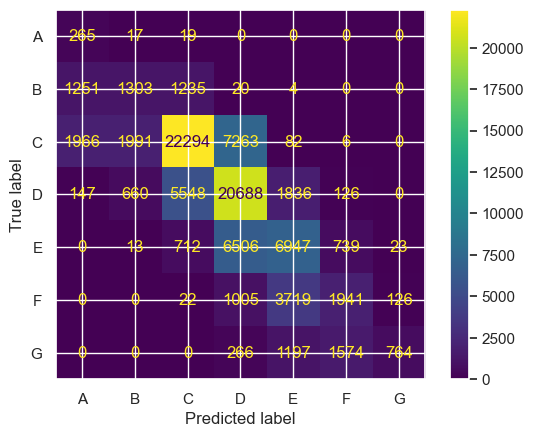

In [186]:
ConfusionMatrixDisplay.from_predictions(df_pred["Etiquette_DPE"], df_pred["etiquette_predite"])

In [187]:
accuracy = accuracy_score(df_pred["Etiquette_DPE"], df_pred["etiquette_predite"], normalize=True)
print("Le taux de prédictions correctes:",accuracy.round(2))

Le taux de prédictions correctes: 0.59


### Régression polynomiale de degré 2

In [188]:

poly_model = make_pipeline(PolynomialFeatures(degree=2), linear_model.LinearRegression())

In [189]:
poly_model.fit(X_train_s,y_train_s)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [190]:
y_pred_test_s = poly_model.predict(X_test_s)
y_pred_train_s = poly_model.predict(X_train_s)

# Évaluation du modèle
mae_train = mean_absolute_error(y_train_s, y_pred_train_s)
mae_test = mean_absolute_error(y_test_s, y_pred_test_s)
score = r2_score(y_train_s, y_pred_train_s)

print("Le score du modèle:", score)
print("L’erreur moyenne absolue pour les données d’entrainement:",mae_train)
print("L’erreur moyenne absolue pour les données du test:",mae_test)

Le score du modèle: 0.8329397901901179
L’erreur moyenne absolue pour les données d’entrainement: 14.601704273154022
L’erreur moyenne absolue pour les données du test: 14.874340140317674


In [191]:
predictions = poly_model.predict(X_s)
df_pred['conso_predite_s'] = [predictions[i][0] for i in  range(0,92275)]
df_pred['emission_predite_s'] = [predictions[i][1] for i in  range(0,92275)]

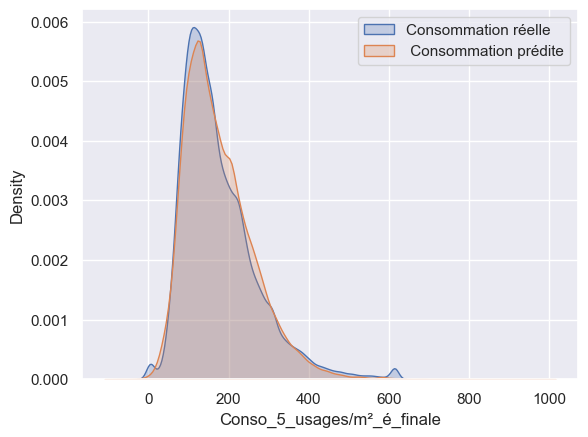

In [192]:
sns.kdeplot(data=df_pred, x='Conso_5_usages/m²_é_finale', fill='Conso_5_usages/m²_é_finale', label="Consommation réelle")
sns.kdeplot(data=df_pred, x="conso_predite_s", fill="conso_predite_s", label=" Consommation prédite")
plt.legend()

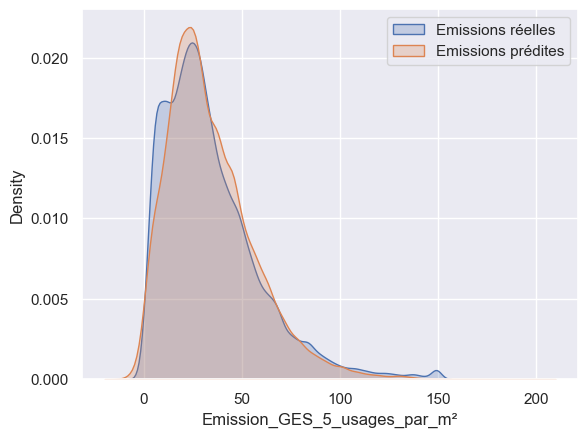

In [193]:
sns.kdeplot(data=df_pred, x='Emission_GES_5_usages_par_m²', fill='Emission_GES_5_usages_par_m²', label="Emissions réelles")
sns.kdeplot(data=df_pred, x="emission_predite_s", fill="emission_predite_s", label="Emissions prédites")
plt.legend()

In [194]:
residus_emission =  df_pred["Emission_GES_5_usages_par_m²"] - df_pred["emission_predite_s"]

residus_consommation =  df_pred["Conso_5_usages/m²_é_finale"] - df_pred["conso_predite_s"]


In [195]:
residus_emission.describe()

count    92275.000000
mean         0.001786
std         10.559050
min        -98.069731
25%         -4.531958
50%          0.020311
75%          4.183242
max        133.463300
dtype: float64

In [196]:
residus_consommation.describe()

count    92275.000000
mean         0.000887
std         37.190837
min       -426.799660
25%        -15.233473
50%         -1.300191
75%         12.751784
max        437.331366
dtype: float64

* Analyse des résidus

Les erreurs de prédiction des deux ont des moyennes proches de 0, avec des écarts-type assez élevés, Cela suggère une variabilité significative dans la performance du modèle. Les valeurs maximales sont importantes, on peut expliquer cela par la présence des outliers dans l’échantillon.

In [197]:
df_pred["etiquette_predite"] = df_pred.apply(remplissage,axis=1)

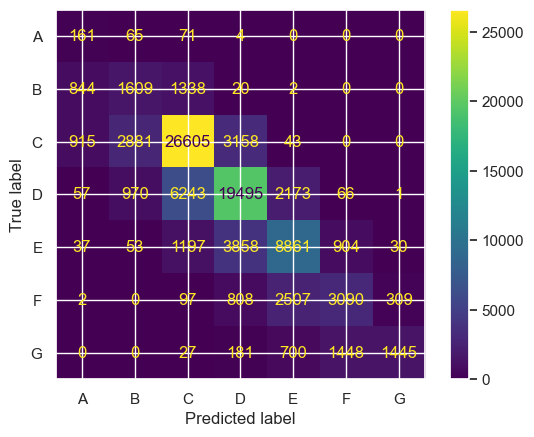

In [198]:
ConfusionMatrixDisplay.from_predictions(df_pred["Etiquette_DPE"], df_pred["etiquette_predite"])

In [199]:
accuracy = accuracy_score(df_pred["Etiquette_DPE"], df_pred["etiquette_predite"], normalize=True)
print("Le taux de prédictions correctes:",accuracy.round(2))

Le taux de prédictions correctes: 0.66


## Autres modèles testés

Nous avons essayé d’autres modèles et d’autres méthodes de préparation de données:

* Suppression des valeurs aberrantes avec la méthode IsolationForest (fonction remove_outliers), le coefficient retenu pour la regression de Lasso est 1, peu de variables explicatives sont retenues, la précision du modèle polynomial augmente (elle vaut 0.99), mais la précision de la classification de l’étiquette DPE diminue, elle passe de 0,68 à 0,62.\
Par rapport aux résidus: l’erreur moyenne pour le volume des émissions est proche de 0, son écart-type est de l’ordre de 13, et les quantiles à 25% et 75% sont respectivement -5,4 et 4,2, les erreurs sont alors regroupées autour de la moyenne 0 avec quelques valeurs extremes ( le max est 308,7 et le min est -433,7)
L’erreur de la prédiction de la consommation est plus dispersée, son écart-type est de 50,1 , sa moyenne est 0,11 et des quartiles sont -19,8 et 14,6.\
La régression polynomiale de degré 2 avec des valeurs aberrantes supprimées par IsolationForest présente l’avantage de minimiser le nombre de variables utilisées pour la prédiction, mais elle affecte légèrement la précision de la classification basée sur les valeurs prédites.

<img src="output.png"  width="600" height="550">




* ElasticNet dans un modèle polynomial de degré 2 : accuracy=0.6 et mauvaise prédiction des valeurs extrêmes.

# FIN DU NOTEBOOK
